In [ ]:
#default_exp core.schedules

In [ ]:
# hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig

nbdev_path = str(NbdevConfig().path("nbs_path")/'data')
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

# Learning Rate Schedules
> LRSchedulers to scheduler learning rate.

In [ ]:
# export
from typing import *
import math
import torch

from fvcore.common.param_scheduler import *

In [ ]:
# hide
# for test
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# export
class LRMultiplier(torch.optim.lr_scheduler._LRScheduler):
    """
    A LRScheduler which uses fvcore  `ParamScheduler` to multiply the
    learning rate of each param in the optimizer.
    Every step, the learning rate of each parameter becomes its initial value
    multiplied by the output of the given `ParamScheduler`.
    The absolute learning rate value of each parameter can be different.
    This scheduler can be used as long as the relative scale among them do
    not change during training.
    """

    # NOTES: in the most general case, every LR can use its own scheduler.
    # Supporting this requires interaction with the optimizer when its parameter
    # group is initialized. For example, classyvision implements its own optimizer
    # that allows different schedulers for every parameter group.
    # To avoid this complexity, we use this class to support the most common cases
    # where the relative scale among all LRs stay unchanged during training.  In this
    # case we only need a total of one scheduler that defines the relative LR multiplier.

    def __init__(self, optimizer: torch.optim.Optimizer, multiplier: ParamScheduler, max_iter: int, last_iter: int = -1,):
        """
        Args:
            optimizer, last_iter: See ``torch.optim.lr_scheduler._LRScheduler``.
                ``last_iter`` is the same as ``last_epoch``.
            multiplier: a fvcore ParamScheduler that defines the multiplier on
                every LR of the optimizer
            max_iter: the total number of training iterations
        """
        if not isinstance(multiplier, ParamScheduler):
            raise ValueError(
                "_LRMultiplier(multiplier=) must be an instance of fvcore "
                f"ParamScheduler. Got {multiplier} instead."
            )
        self._multiplier = multiplier
        self._max_iter = max_iter
        super().__init__(optimizer, last_epoch=last_iter)

    def state_dict(self):
        # fvcore schedulers are stateless. Only keep pytorch scheduler states
        return {"base_lrs": self.base_lrs, "last_epoch": self.last_epoch}

    def get_lr(self) -> List[float]:
        multiplier = self._multiplier(self.last_epoch / self._max_iter)
        return [base_lr * multiplier for base_lr in self.base_lrs]

In [ ]:
show_doc(LRMultiplier)

<h2 id="LRMultiplier" class="doc_header"><code>class</code> <code>LRMultiplier</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>LRMultiplier</code>(**`optimizer`**:`Optimizer`, **`multiplier`**:`ParamScheduler`, **`max_iter`**:`int`, **`last_iter`**:`int`=*`-1`*) :: `_LRScheduler`

A LRScheduler which uses fvcore  `ParamScheduler` to multiply the
learning rate of each param in the optimizer.
Every step, the learning rate of each parameter becomes its initial value
multiplied by the output of the given `ParamScheduler`.
The absolute learning rate value of each parameter can be different.
This scheduler can be used as long as the relative scale among them do
not change during training.

Example - 

In [ ]:
lrs   = []

epoch = 10
batch_nb = 10

model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
optim = torch.optim.Adam(model, lr=0.1)

scheduler = LRMultiplier(optim, max_iter=epoch*batch_nb, multiplier=CosineParamScheduler(1, 0))

for _ in range(epoch):
    for _ in range(batch_nb):
        scheduler.step()
        lrs.append(scheduler.get_lr())

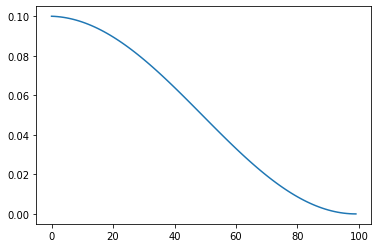

In [ ]:
#hide-input
plt.plot(lrs);

## FlatCos scheduling

In [ ]:
#export
def FlatCos(optimizer: torch.optim.Optimizer, pct_start: float, max_iters: int):
    """
    Schedule the LearningRate at flat `lr` for `pct_start` of `max_iters` before cosine annealing.  
    Inspired From - https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos
    """
    
    schedulers = [LinearParamScheduler(1, 1), CosineParamScheduler(1, 0)]
    # create CompositeParamScheduler Class
    sched = CompositeParamScheduler(schedulers, lengths=[pct_start, 1-pct_start], 
                                    interval_scaling=['rescaled', 'rescaled'])
    
    # Wrap Param Scheduler under LRMultiplier class
    sched = LRMultiplier(optimizer, sched, max_iter=max_iters)
    return sched

In [ ]:
show_doc(FlatCos)

<h4 id="FlatCos" class="doc_header"><code>FlatCos</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>FlatCos</code>(**`optimizer`**:`Optimizer`, **`pct_start`**:`float`, **`max_iters`**:`int`)

Schedule the LearningRate at flat `lr` for `pct_start` of `max_iters` before cosine annealing.  
Inspired From - https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos

In [ ]:
lrs = []

epochs   = 10
batch_nb = 10

optim = torch.optim.Adam(model, lr=0.1)
scheduler = FlatCos(optim, pct_start=0.75, max_iters=epochs*batch_nb)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        # call scheduler after a single training step
        scheduler.step()
        lrs.append(scheduler.get_lr())

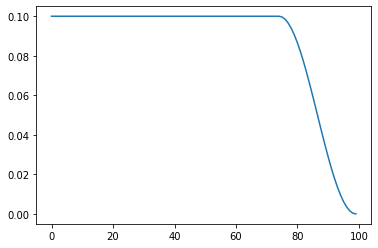

In [ ]:
#hide-input
plt.plot(lrs);

## WarmupParamScheduler

In [ ]:
# export
class WarmupParamScheduler(CompositeParamScheduler):
    """
    Add an initial warmup stage to another scheduler.
    From - https://github.com/facebookresearch/fvcore/blob/master/fvcore/common/param_scheduler.py
    """

    def __init__(self, scheduler: ParamScheduler, warmup_factor: float, warmup_length: float, warmup_method: str = "linear",):
        """
        Args:
            scheduler: warmup will be added at the beginning of this scheduler
            warmup_factor: the factor w.r.t the initial value of ``scheduler``, e.g. 0.001
            warmup_length: the relative length (in [0, 1]) of warmup steps w.r.t the entire
                training, e.g. 0.01
            warmup_method: one of "linear" or "constant"
        """
        end_value   = scheduler(warmup_length)  # the value to reach when warmup ends
        start_value = warmup_factor * scheduler(0.0)
        if warmup_method == "constant":
            warmup = ConstantParamScheduler(start_value)
        elif warmup_method == "linear":
            warmup = LinearParamScheduler(start_value, end_value)
        else:
            raise ValueError("Unknown warmup method: {}".format(warmup_method))
        super().__init__([warmup, scheduler], interval_scaling=["rescaled", "fixed"],
                         lengths=[warmup_length, 1 - warmup_length],)

In [ ]:
show_doc(WarmupParamScheduler)

<h2 id="WarmupParamScheduler" class="doc_header"><code>class</code> <code>WarmupParamScheduler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>WarmupParamScheduler</code>(**`scheduler`**:`ParamScheduler`, **`warmup_factor`**:`float`, **`warmup_length`**:`float`, **`warmup_method`**:`str`=*`'linear'`*) :: `CompositeParamScheduler`

Add an initial warmup stage to another scheduler.
From - https://github.com/facebookresearch/fvcore/blob/master/fvcore/common/param_scheduler.py

In [ ]:
# export
def WarmupCosineLR(optimizer: torch.optim.Optimizer, warmup_iters: int, max_iters: int):
    "Linearly increase `lr` for `warmup_iters` before cosine annealing. "
    sched = CosineParamScheduler(1, 0)
    sched = WarmupParamScheduler(sched, warmup_factor=(1.0 / 1000), 
                                 warmup_length=warmup_iters/max_iters, 
                                 warmup_method="linear")
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

In [ ]:
show_doc(WarmupCosineLR)

<h4 id="WarmupCosineLR" class="doc_header"><code>WarmupCosineLR</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>WarmupCosineLR</code>(**`optimizer`**:`Optimizer`, **`warmup_iters`**:`int`, **`max_iters`**:`int`)

Linearly increase `lr` for `warmup_iters` before cosine annealing. 

In [ ]:
lrs = []

epochs   = 10
batch_nb = 20

scheduler = WarmupCosineLR(optim, warmup_iters=20, max_iters=epochs*batch_nb)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        # call scheduler after a single training step
        scheduler.step()
        lrs.append(scheduler.get_lr())

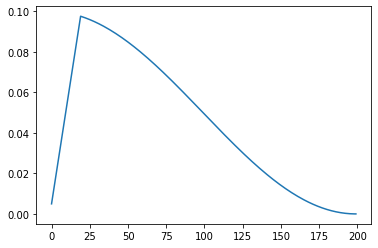

In [ ]:
#hide-input
plt.plot(lrs);

In [ ]:
# export
def WarmupLinearLR(optimizer: torch.optim.Optimizer, warmup_iters: int, max_iters: int):
    "Linearly increase `lr` for `warmup_iters` before linearly decreasing the `lr`"
    sched = LinearParamScheduler(1, 0)
    sched = WarmupParamScheduler(sched, warmup_factor=(1.0 / 1000), 
                                 warmup_length=warmup_iters/max_iters, 
                                 warmup_method="linear")
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

In [ ]:
show_doc(WarmupLinearLR)

<h4 id="WarmupLinearLR" class="doc_header"><code>WarmupLinearLR</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>WarmupLinearLR</code>(**`optimizer`**:`Optimizer`, **`warmup_iters`**:`int`, **`max_iters`**:`int`)

Linearly increase `lr` for `warmup_iters` before linearly decreasing the `lr`

In [ ]:
lrs = []

epochs   = 10
batch_nb = 20

scheduler = WarmupLinearLR(optim, warmup_iters=20, max_iters=epochs*batch_nb)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        # call scheduler after a single training step
        scheduler.step()
        lrs.append(scheduler.get_lr())

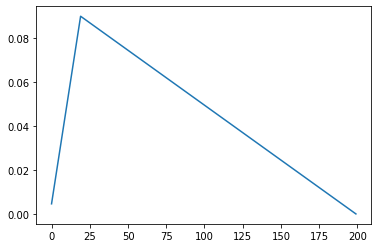

In [ ]:
#hide-input
plt.plot(lrs);

In [ ]:
# export
def WarmupConstantLR(optimizer: torch.optim.Optimizer, warmup_iters: int, max_iters: int):
    "Linearly increase `lr` for `warmup_iters` after which keep `lr` at constant value"
    sched = LinearParamScheduler(1, 1)
    sched = WarmupParamScheduler(sched, warmup_factor=(1.0 / 1000), 
                                 warmup_length=warmup_iters/max_iters, 
                                 warmup_method="linear")
    return LRMultiplier(optimizer, multiplier=sched, max_iter=max_iters)

In [ ]:
show_doc(WarmupConstantLR)

<h4 id="WarmupConstantLR" class="doc_header"><code>WarmupConstantLR</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>WarmupConstantLR</code>(**`optimizer`**:`Optimizer`, **`warmup_iters`**:`int`, **`max_iters`**:`int`)

Linearly increase `lr` for `warmup_iters` after which keep `lr` at constant value

In [ ]:
lrs = []

epochs   = 10
batch_nb = 20

scheduler = WarmupConstantLR(optim, warmup_iters=20, max_iters=epochs*batch_nb)

for _ in range(epoch):
    for _ in range(batch_nb):
        optim.step()
        # call scheduler after a single training step
        scheduler.step()
        lrs.append(scheduler.get_lr())

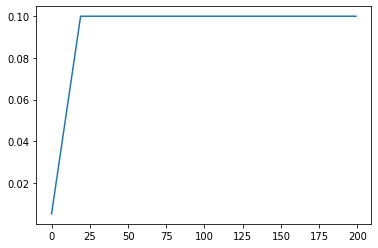

In [ ]:
#hide-input
plt.plot(lrs);

## LR_SCHEDULER_REGISTERY
> Registery of LRSchedulers

In [ ]:
# export
from torch.optim import Optimizer
from omegaconf import DictConfig
from lightning_cv.core.common import Registry
from torch.optim.lr_scheduler import (OneCycleLR, CosineAnnealingWarmRestarts, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau, MultiplicativeLR)

In [ ]:
# export
LR_SCHEDULER_REGISTERY = Registry("LRSchedulers")

In [ ]:
# export
# torch schedulers
LR_SCHEDULER_REGISTERY.register(OneCycleLR)
LR_SCHEDULER_REGISTERY.register(CosineAnnealingWarmRestarts)
LR_SCHEDULER_REGISTERY.register(StepLR)
LR_SCHEDULER_REGISTERY.register(MultiStepLR)
LR_SCHEDULER_REGISTERY.register(ExponentialLR)
LR_SCHEDULER_REGISTERY.register(ReduceLROnPlateau)
LR_SCHEDULER_REGISTERY.register(MultiplicativeLR)

# custom schedulers
LR_SCHEDULER_REGISTERY.register(FlatCos)
LR_SCHEDULER_REGISTERY.register(WarmupCosineLR)
LR_SCHEDULER_REGISTERY.register(WarmupLinearLR)
LR_SCHEDULER_REGISTERY.register(WarmupConstantLR)

In [ ]:
#hide-inputs
LR_SCHEDULER_REGISTERY

Registry of LRSchedulers:
╒═════════════════════════════╤════════════════════════════════════════════════════════════════╕
│ Names                       │ Objects                                                        │
╞═════════════════════════════╪════════════════════════════════════════════════════════════════╡
│ OneCycleLR                  │ <class 'torch.optim.lr_scheduler.OneCycleLR'>                  │
├─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ CosineAnnealingWarmRestarts │ <class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'> │
├─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ StepLR                      │ <class 'torch.optim.lr_scheduler.StepLR'>                      │
├─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ MultiStepLR                 │ <class 'torch.optim.lr_scheduler.MultiStepLR'>                 │
├───

In [ ]:
# export
def create_scheduler(opt: Optimizer,  cfg: DictConfig, n_epochs: int, n_steps: int) -> Dict:
    """
    Instantiate a scheduler from `LR_SCHEDULER_REGISTERY` given `opt` from `cfg`, `n_epochs` & `n_steps`.
    
    > Note: Returned scheduler will be in a format similar
    [scheduler configuration](https://pytorch-lightning.readthedocs.io/en/latest/common/optimizers.html) 
    in pytorch lightning.
    """
    opt_cls = LR_SCHEDULER_REGISTERY.get(cfg.SCHEDULER.NAME)
    
    max_iters = n_epochs * n_steps
    
    keys = ["max_iters", "epochs", "steps_per_epoch"]
    
    for key in keys:
        if key in cfg.SCHEDULER.ARGUMENTS.keys():
            if cfg.SCHEDULER.ARGUMENTS["key"] is None:
                if key == "max_iters":
                    cfg.SCHEDULER.ARGUMENTS.max_iters = max_iters
                elif key == "epochs":
                    cfg.SCHEDULER.ARGUMENTS.epochs = n_epochs
                else:
                    cfg.SCHEDULER.ARGUMENTS.steps_per_epoch = n_steps
        
    sched = opt_cls(optimizer=opt, **cfg.SCHEDULER.ARGUMENTS)
    
    # convert scheduler to lightning format
    return dict(scheduler=sched, monitor=cfg.SCHEDULER.MONITOR, interval=cfg.SCHEDULER.INTERVAL, 
                frequency=cfg.SCHEDULER.FREQUENCY)

In [ ]:
show_doc(create_scheduler)

<h4 id="create_scheduler" class="doc_header"><code>create_scheduler</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>create_scheduler</code>(**`opt`**:`Optimizer`, **`cfg`**:`DictConfig`, **`n_epochs`**:`int`, **`n_steps`**:`int`)

Instantiate a scheduler from `LR_SCHEDULER_REGISTERY` given `opt` from `cfg`, `n_epochs` & `n_steps`.

> Note: Returned scheduler will be in a format similar
[scheduler configuration](https://pytorch-lightning.readthedocs.io/en/latest/common/optimizers.html) 
in pytorch lightning.

In [ ]:
from lightning_cv.config import get_cfg
from omegaconf import OmegaConf

cfg = get_cfg(strict=False)
print(OmegaConf.to_yaml(cfg.SCHEDULER))

NAME: FlatCos
ARGUMENTS:
  pct_start: 0.72
  max_iters: null
INTERVAL: step
FREQUENCY: 1
MONITOR: null



In [ ]:
epoch = 10
batch_nb = 10

model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
optim = torch.optim.Adam(model, lr=0.1)

scheduler = create_scheduler(optim, cfg, n_epochs=epoch, n_steps=batch_nb)
print(scheduler)

{'scheduler': <__main__.LRMultiplier object at 0x7f8376169dc0>, 'monitor': None, 'interval': 'step', 'frequency': 1}


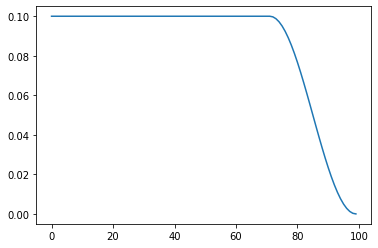

In [ ]:
lrs = []

for _ in range(epoch):
    for _ in range(batch_nb):
        scheduler["scheduler"].step()
        lrs.append(scheduler["scheduler"].get_lr())

plt.plot(lrs);

If you want to use `OneCycleScheduler`

> Note: The scheduler that you want to use must be registerd in the `LR_SCHEDULER_REGISTERY` registery for `create_scheduler` to work. Also if the scheduler you use requires `max_iters`, `epochs`, `steps_per_epoch` in `ARGUMENTS` and if these are None then `lightning_cv` will automatically set these values for you.

In [ ]:
cfg = get_cfg(strict=False)
cfg.SCHEDULER.NAME = "OneCycleLR"
cfg.SCHEDULER.ARGUMENTS = dict(max_lr=1e-03, epochs=None, steps_per_epoch=None, anneal_strategy='cos', cycle_momentum=True,)
cfg.SCHEDULER.INTERVAL = "step"
cfg.SCHEDULER.FREQUENCY = 1
print(OmegaConf.to_yaml(cfg.SCHEDULER))

NAME: OneCycleLR
ARGUMENTS:
  max_lr: 0.001
  epochs: null
  steps_per_epoch: null
  anneal_strategy: cos
  cycle_momentum: true
INTERVAL: step
FREQUENCY: 1
MONITOR: null



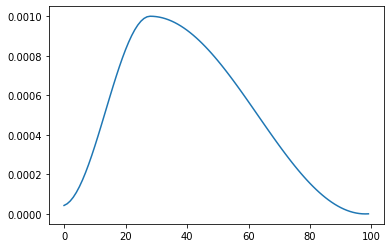

In [ ]:
epoch = 10
batch_nb = 10

model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
optim = torch.optim.Adam(model, lr=0.1)

scheduler = create_scheduler(optim, cfg, n_epochs=epoch, n_steps=batch_nb)

lrs = []

for _ in range(epoch):
    for _ in range(batch_nb):
        scheduler["scheduler"].step()
        lrs.append(scheduler["scheduler"].get_lr())

plt.plot(lrs);

In [ ]:
#hide
notebook2script()

Converted 00_config.ipynb.
Converted 00a_core.common.ipynb.
Converted 00b_core.data_utils.ipynb.
Converted 00c_core.optim.ipynb.
Converted 00d_core.schedules.ipynb.
Converted 00e_core.layers.ipynb.
Converted 01a_classification.data.transforms.ipynb.
Converted 01b_classification.data.datasets.ipynb.
Converted 01c_classification.modelling.body.ipynb.
Converted index.ipynb.
